**Navier Stokes Equations**

Incompressible Fluid Flow - 2D 
Numerical Method - Spectral Solver using NekTar. <br>
Data taken from that used in [this paper](https://www.sciencedirect.com/science/article/pii/S0021999118307125). <br>
```
u_t + (u*u_x + v*u_y) = -p_x + 0.01*(u_xx + u_yy) 
v_t + (u*v_x + v*v_y) = -p_y + 0.01*(v_xx + v_yy) 

u_x + u_y = 0 

on x ∈ [1,8], y ∈ [-2,2], t ∈ [0,20]
```


In [ ]:
"""
2D wave equation via FFT 

u_tt = u_xx + u_yy 

on [-1, 1]x[-1, 1], t > 0 and Dirichlet BC u=0
"""


'\n2D wave equation via FFT \n\nu_tt = u_xx + u_yy \n\non [-1, 1]x[-1, 1], t > 0 and Dirichlet BC u=0\n'

In [ ]:
import os
import time
from tqdm import tqdm 
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt 
%matplotlib inline


!pip install pyDOE
from pyDOE import lhs
import torch
import torch.nn as nn

# %
default_device = "cuda" if torch.cuda.is_available() else "cpu"

dtype=torch.float32
torch.set_default_dtype(dtype)

def torch_tensor_grad(x, device):
    if device == 'cuda':
        x = torch.cuda.FloatTensor(x)
    else:
        x = torch.FloatTensor(x)
    x.requires_grad = True
    return x 

def torch_tensor_nograd(x, device):
    if device == 'cuda':
        x = torch.cuda.FloatTensor(x)
    else:
        x = torch.FloatTensor(x)
    x.requires_grad = False
    return x 



  Created wheel for pyDOE: filename=pyDOE-0.3.8-cp37-none-any.whl size=18178 sha256=c8b93e0332838311aa8c3a4e2e2047f4427ca532b12989340da75f113e403229
  Stored in directory: /root/.cache/pip/wheels/7c/c8/58/a6493bd415e8ba5735082b5e0c096d7c1f2933077a8ce34544
Successfully built pyDOE


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
data_loc = '/content/drive/My Drive/Colab Notebooks/PINNs - PyTorch Ecosystem Day/Data/'

import scipy.io

data = scipy.io.loadmat(data_loc +'cylinder_nektar_wake.mat')


# Load Data
       
U_star = data['U_star'] # N x 2 x T
P_star = data['p_star'] # N x T
t_star = data['t'] # T x 1
X_star = data['X_star'] # N x 2

N = X_star.shape[0]
T = t_star.shape[0]

# Rearrange Data 
XX = np.tile(X_star[:,0:1], (1,T)) # N x T
YY = np.tile(X_star[:,1:2], (1,T)) # N x T
TT = np.tile(t_star, (1,N)).T # N x T

UU = U_star[:,0,:] # N x T
VV = U_star[:,1,:] # N x T
PP = P_star # N x T

x = XX.flatten()[:,None] # NT x 1
y = YY.flatten()[:,None] # NT x 1
t = TT.flatten()[:,None] # NT x 1

u = UU.flatten()[:,None] # NT x 1
v = VV.flatten()[:,None] # NT x 1
p = PP.flatten()[:,None] # NT x 1


# Training Data    
idx = np.random.choice(N*T, 5000, replace=False)
x_train = x[idx,:]
y_train = y[idx,:]
t_train = t[idx,:]

u_train = u[idx,:]
v_train = v[idx,:]
p_train = p[idx,:]

X_train = np.column_stack((x_train, y_train, t_train))
Y_train = np.column_stack((u_train, v_train, p_train))

In [ ]:
# Setting the random seed. 
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

In [ ]:
#Setting up a Resnet as the PINN. 
class Resnet(nn.Module):
    def __init__(self, in_features, out_features, num_neurons, activation=torch.sin):
        super(Resnet, self).__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        self.num_neurons = num_neurons
        
        self.act_func = activation
        
        self.block1_layer1 = nn.Linear(self.in_features, self.num_neurons)
        self.block1_layer2 = nn.Linear(self.num_neurons, self.num_neurons)
        self.block1 = [self.block1_layer1, self.block1_layer2]
        
        self.block2_layer1 = nn.Linear(self.in_features + self.num_neurons, self.num_neurons)
        self.block2_layer2 = nn.Linear(self.num_neurons, self.num_neurons)
        self.block2 = [self.block2_layer1, self.block2_layer2]
        
        # self.block3_layer1 = nn.Linear(self.in_features + self.num_neurons, self.num_neurons)
        # self.block3_layer2 = nn.Linear(self.num_neurons, self.num_neurons)
        # self.block3 = [self.block3_layer1, self.block3_layer2]
        
        # self.block4_layer1 = nn.Linear(self.in_features + self.num_neurons, self.num_neurons)
        # self.block4_layer2 = nn.Linear(self.num_neurons, self.num_neurons)
        # self.block4 = [self.block4_layer1, self.block4_layer2]
        
        self.layer_after_block = nn.Linear(self.num_neurons + self.in_features, self.num_neurons)
        self.layer_output = nn.Linear(self.num_neurons, self.out_features)
        
        
    def forward(self, x):
        
        x_temp = x
        
        for dense in self.block1:
            x_temp = self.act_func(dense(x_temp))
        x_temp = torch.cat([x_temp, x], dim=-1)
        
        for dense in self.block2:
            x_temp = self.act_func(dense(x_temp))
        x_temp = torch.cat([x_temp, x], dim=-1)
        
        # for dense in self.block3:
        #    x_temp = self.act_func(dense(x_temp))           
        # x_temp = torch.cat([x_temp, x], dim=-1)
        
        # for dense in self.block4:
        #    x_temp = self.act_func(dense(x_temp))
        # x_temp = torch.cat([x_temp, x], dim=-1)
        
        x_temp = self.act_func(self.layer_after_block(x_temp))
        x_temp = self.layer_output(x_temp)
        return x_temp

#Setting up a derivative function that goes through the graph and calculates via chain rule the derivative of u wrt x 
deriv = lambda u, x: torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True, allow_unused=True)[0]


In [ ]:
#Setting up an instance of the Resnet with the needed architecture. 
npde_net = Resnet(3, 3, 100)
npde_net = npde_net.to(default_device)


In [ ]:
#Specifying the Domain of Interest. 
x_range = [1.0, 8.0]
y_range = [-2.0, 2.0]
t_range = [0.0, 20.0]

lb = np.asarray([x_range[0], y_range[0], t_range[0]])
ub = np.asarray([x_range[1], y_range[1], t_range[1]])

def LHS_Sampling(N):
    return lb + (ub-lb)*lhs(3, N)


In [ ]:
def recon_loss(X, Y):
    return 7*4*(npde_net(X) - Y).pow(2).mean()

def velocity_loss(X, Y):
    out = npde_net(X)
 
    u_f = out[:, 0:1] - Y[:, 0:1]
    v_f = out[:, 1:2] - Y[:, 1:2]

    f = 7*4*20*(u_f + v_f).pow(2).mean()
    return f

def pressure_loss(X, Y):
    out = npde_net(X)

    p_f = out[:, 2:3] - Y[:, 2:3]

    f = 7*4*20*p_f.pow(2).mean()
    return f
    
def npde_loss(X):

    x = X[:, 0:1]
    y = X[:, 1:2]
    t = X[:, 2:3]    

    out = npde_net(torch.cat([x,y,t],1))


    u = out[:, 0:1]
    v = out[:, 1:2]
    p = out[:, 2:3]
    
    u_t = deriv(u, t)
    v_t = deriv(v, t)
    
    u_x = deriv(u, x)
    v_x = deriv(v, x)
    p_x = deriv(p, x)
    
    u_y = deriv(u, y)
    v_y = deriv(v, y)
    p_y = deriv(p, y)
    
    u_xx = deriv(u_x, x)
    v_xx = deriv(v_x, x)
    
    u_yy = deriv(u_y, y)
    v_yy = deriv(v_y, y)
    
    f_u = u_t + (u*u_x + v*u_y) + p_x - 0.01*(u_xx + u_yy) 
    f_v = v_t + (u*v_x + v*v_y) + p_y - 0.01*(v_xx + v_yy)
    
    continuity = (u_x + v_y)

    f = 7*4*20*(f_u + f_v + continuity).pow(2).mean()
    return f


In [ ]:
#Normalisation Strategies
def min_max_norm(x):
    return 2*(x-np.min(x))/(np.max(x)-np.min(x)) - 1

def z_score(x):
    return (x-np.mean(x)) / np.std(x)

def identity(x):
  return x


In [ ]:
#Samples taken from each region for optimisation purposes. 
N_i = 5000
# N_b = 1000
N_f = 20000

In [ ]:
# Data for Initial Input 

x = X_star[:100, 0]
           
y = []
for ii in range(0, len(X_star), 100):
    y.append(X_star[ii, 1])
y = np.asarray(y)

t_range = t[:200, 0]

xx, yy = np.meshgrid(x,y)
tt = np.repeat(t_range, len(x)*len(y))

X_pred = np.column_stack((np.tile(xx.flatten(), len(t_range)), 
                     np.tile(yy.flatten(), len(t_range)), tt))

u_exact = np.reshape(U_star[:, 0, :].transpose(), (200, 50, 100))
v_exact = np.reshape(U_star[:, 1, :].transpose(), (200, 50, 100))
p_exact = np.reshape(P_star.transpose(), (200, 50, 100))

X_ic = X_pred[0:5000]
U_ic = np.expand_dims(UU.transpose()[0].flatten(), axis=-1)
V_ic = np.expand_dims(VV.transpose()[0].flatten(), axis=-1)
P_ic = np.expand_dims(PP.transpose()[0].flatten(), axis=-1)

Y_ic = np.column_stack((U_ic, V_ic, P_ic))



In [ ]:
#Data for Domain Input
X_f = LHS_Sampling(N_f)

In [ ]:
#Converting to tensors 

X_ic_torch = torch_tensor_grad(X_ic, default_device)
Y_ic_torch = torch_tensor_grad(Y_ic, default_device)
X_f_torch = torch_tensor_grad(X_f, default_device)
X_train_torch = torch_tensor_grad(X_train, default_device)
Y_train_torch = torch_tensor_nograd(Y_train, default_device)

In [ ]:
#Training Loop
optimizer = torch.optim.Adam(npde_net.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5000, gamma=0.9)

it=0
epochs = 20000
loss_list = []

start_time = time.time()
while it < epochs :
    optimizer.zero_grad()

    domain_loss = npde_loss(X_f_torch)
    ic_loss = recon_loss(X_ic_torch, Y_ic_torch)
    uv_loss = velocity_loss(X_train_torch, Y_train_torch)
    p_loss = pressure_loss(X_train_torch, Y_train_torch)
    data_loss = p_loss + uv_loss
    
    loss = domain_loss + ic_loss + data_loss
    loss_list.append(loss.item())
    
    loss.backward()
    optimizer.step()
    scheduler.step()

    it += 1

    print('It: %d, Init: %.3e, Data: %.3e, Domain: %.3e' % (it, ic_loss.item(), data_loss.item(), domain_loss.item()))



Streaming output truncated to the last 5000 lines.
It: 15001, Init: 3.813e-03, Data: 2.845e-02, Domain: 8.155e-03
It: 15002, Init: 3.448e-03, Data: 3.875e-02, Domain: 1.091e-02
It: 15003, Init: 3.806e-03, Data: 2.511e-02, Domain: 7.440e-03
It: 15004, Init: 3.579e-03, Data: 1.281e-02, Domain: 3.993e-03
It: 15005, Init: 3.504e-03, Data: 1.977e-02, Domain: 5.657e-03
It: 15006, Init: 3.832e-03, Data: 2.902e-02, Domain: 8.218e-03
It: 15007, Init: 3.489e-03, Data: 2.360e-02, Domain: 6.922e-03
It: 15008, Init: 3.664e-03, Data: 1.343e-02, Domain: 4.038e-03
It: 15009, Init: 3.680e-03, Data: 1.509e-02, Domain: 4.324e-03
It: 15010, Init: 3.494e-03, Data: 2.250e-02, Domain: 6.378e-03
It: 15011, Init: 3.776e-03, Data: 2.109e-02, Domain: 6.143e-03
It: 15012, Init: 3.546e-03, Data: 1.419e-02, Domain: 4.302e-03
It: 15013, Init: 3.584e-03, Data: 1.316e-02, Domain: 3.790e-03
It: 15014, Init: 3.731e-03, Data: 1.781e-02, Domain: 5.004e-03
It: 15015, Init: 3.509e-03, Data: 1.892e-02, Domain: 5.510e-03
It: 

Text(0, 0.5, 'L2 Error')

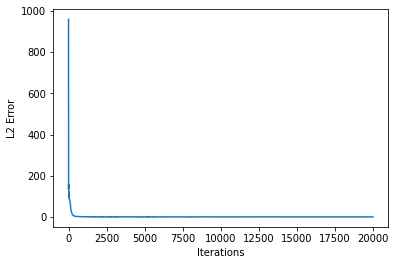

In [ ]:
train_time = time.time() - start_time
plt.plot(loss_list)
plt.xlabel('Iterations')
plt.ylabel('L2 Error')

In [ ]:
inp = torch_tensor_grad(X_pred, default_device)

  #Getting the trained output. 
if default_device == 'cpu':
    with torch.no_grad():
        out_pred = npde_net(inp).detach().numpy()

else : 
    with torch.no_grad():
        out_pred = npde_net(inp).cpu().detach().numpy()

u_pred = out_pred[:, 0:1]
v_pred = out_pred[:, 1:2]
p_pred = out_pred[:, 2:3]

out = np.column_stack((u, v, p))

l2_error = np.mean((out - out_pred)**2) 

print('Training Time: %d seconds, L2 Error: %.3e' % (train_time, l2_error))

u_pred = np.reshape(u_pred, np.shape(u_exact))
u_actual = u_exact

v_pred = np.reshape(v_pred, np.shape(v_exact))
v_actual = v_exact

p_pred = np.reshape(p_pred, np.shape(p_exact))
p_actual = p_exact



Training Time: 1259 seconds, L2 Error: 1.069e-01


In [ ]:
torch.save(npde_net.state_dict(), '/content/drive/My Drive/Colab Notebooks/PINNs - PyTorch Ecosystem Day/Saved Models/NavierStokesModel.pth')

In [30]:
npde_net = Resnet(3, 3, 100)
npde_net = npde_net.to(default_device)
npde_net.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/PINNs - PyTorch Ecosystem Day/Saved Models/NavierStokesModel.pth'))


<All keys matched successfully>

In [31]:
!pip install celluloid
from celluloid import Camera
from IPython.display import HTML

def animate(data):
  fig = plt.figure()
  camera = Camera(fig)
  for ii in range(len(data)):
      plt.imshow(data[ii])
      camera.snap()
  animation = camera.animate()

  return animation

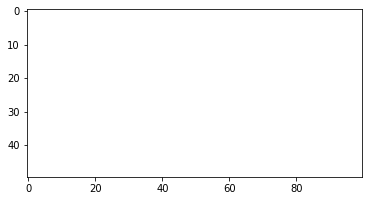

In [32]:
animation = animate(p_actual)
HTML(animation.to_html5_video())


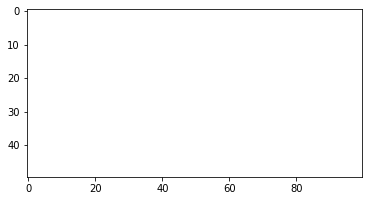

In [33]:
animation = animate(p_pred)
HTML(animation.to_html5_video())

In [34]:
from matplotlib import cm
from matplotlib import animation

def animation_plot(name, data, z):
    wave_name = name
    u_field = data
    xx, yy = np.meshgrid(x,y)


    def update_plot(frame_number, u_field, plot):
        plot[0].remove()
        plot[0] = ax.plot_surface(xx, yy, u_field[frame_number], cmap=cm.coolwarm, linewidth=2, antialiased=False)
        
        
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    plot = [ax.plot_surface(xx, yy, u_field[0], cmap=cm.coolwarm, linewidth=2, antialiased=False)]
    ax.set_xlim3d(1.0, 8.0)
    ax.set_ylim3d(-2.0, 2.0)
    # ax.set_zlim3d(-0.6, 0.1)

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel(z)
    ax.set_title(wave_name)

    # ax.set_xticks([-1.0, -0.5, 0.0, 0.5, 1.0])
    # ax.set_yticks([-1.0, -0.5, 0.0, 0.5, 1.0])

    #plt.tight_layout()
    ax.view_init(elev=30., azim=-110)


    fps = 50 # frame per sec
    frn = len(u_field) # frame number of the animation

    anim = animation.FuncAnimation(fig, update_plot, frn, fargs=(u_field, plot), interval=1000/fps)
    return anim

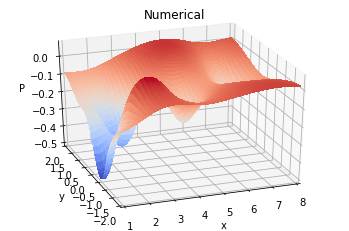

In [35]:
animate = animation_plot('Numerical', p_actual, 'P')
HTML(animate.to_html5_video())

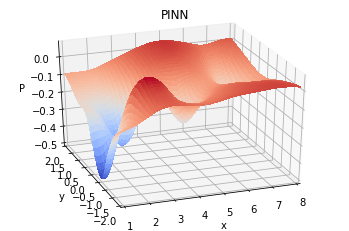

In [36]:
animate = animation_plot('PINN', p_pred, 'P')
HTML(animate.to_html5_video())

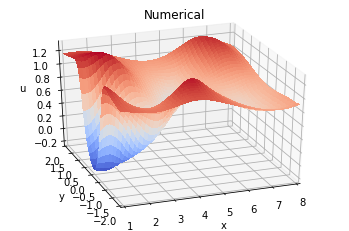

In [37]:
animate = animation_plot('Numerical', u_actual, 'u')
HTML(animate.to_html5_video())

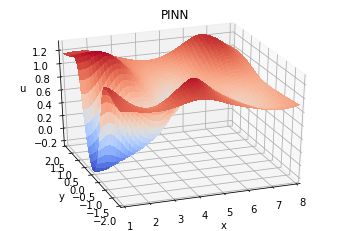

In [38]:
animate = animation_plot('PINN', u_pred, 'u')
HTML(animate.to_html5_video())

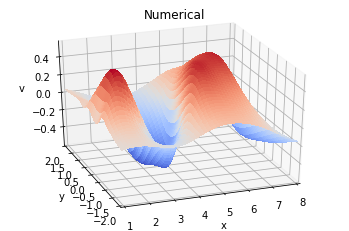

In [39]:
animate = animation_plot('Numerical', v_actual, 'v')
HTML(animate.to_html5_video())

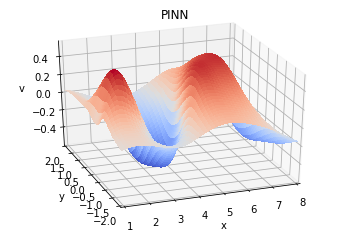

In [40]:
animate = animation_plot('PINN', v_pred, 'v')
HTML(animate.to_html5_video())

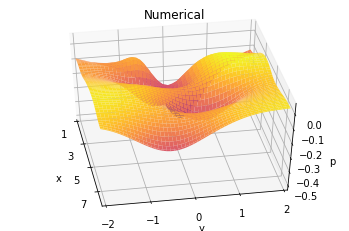

In [73]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim3d(1.0, 8.0)
ax.set_ylim3d(-2.0, 2.0)
# ax.set_zlim3d(-0.4, 0.4)

plot = ax.plot_surface(xx, yy, p_pred[100], cmap=cm.plasma, linewidth=2, antialiased=True)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("p")
ax.set_title("Numerical")

ax.set_xticks([1.0, 3.0, 5.0, 7.0])
ax.set_yticks([-2.0, -1.0, 0.0, 1.0, 2.0])
# ax.set_zticks([-0.4, -0.2, 0.0, 0.2, 0.4])

ax.view_init(elev=45., azim=-10)
